In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(7)

In [2]:
import os
os.listdir()

['.ipynb_checkpoints',
 'acea-water-prediction.zip',
 'Aquifer_Petrignano.csv',
 'Forecasting of Aquifer Layer (Depth of GroundWater) in Univariate case using Arima Model.ipynb',
 'Orisinal_script.ipynb',
 'univariate_df.csv']

In [3]:
df = pd.read_csv('Aquifer_Petrignano.csv')
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [4]:
## remove column (not usefull)
df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1, inplace=True)
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.18,NaN,NaN,NaN
1,15/03/2006,NaN,-22.14,NaN,NaN,NaN
2,16/03/2006,NaN,-22.04,NaN,NaN,NaN
3,17/03/2006,NaN,-22.04,NaN,NaN,NaN
4,18/03/2006,NaN,-22.04,NaN,NaN,NaN


In [5]:
df.shape

(5223, 6)

In [6]:
df.isnull().sum()

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
dtype: int64

In [7]:
df.dropna(subset=['Rainfall_Bastia_Umbra'], inplace=True)
df.isnull().sum()

Date                                     0
Rainfall_Bastia_Umbra                    0
Depth_to_Groundwater_P25                27
Temperature_Bastia_Umbra                 0
Volume_C10_Petrignano                    1
Hydrometry_Fiume_Chiascio_Petrignano     0
dtype: int64

In [8]:
## rename column
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 
              'river_hydrometry']
df.reset_index(drop=True, inplace=True)
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [9]:
targets = df['depth_to_groundwater']
features = df.drop(['depth_to_groundwater'], axis=1)

### Parse Date to Datetime column

In [10]:
from datetime import datetime, date 

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  4199 non-null   datetime64[ns]
 1   rainfall              4199 non-null   float64       
 2   depth_to_groundwater  4172 non-null   float64       
 3   temperature           4199 non-null   float64       
 4   drainage_volume       4198 non-null   float64       
 5   river_hydrometry      4199 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 197.0 KB


## Data Visualization

Note:

- Rainfall = kuantitas rainfall (mm)
- Temperature = suhu (C)
- Volume = volume yang diambil untuk tempat pengolahan air minum
- Hydrometery = indikasi groundwater level (m)

- depth_to_groundwater = indikasi level groundwater(m dari ground floor)

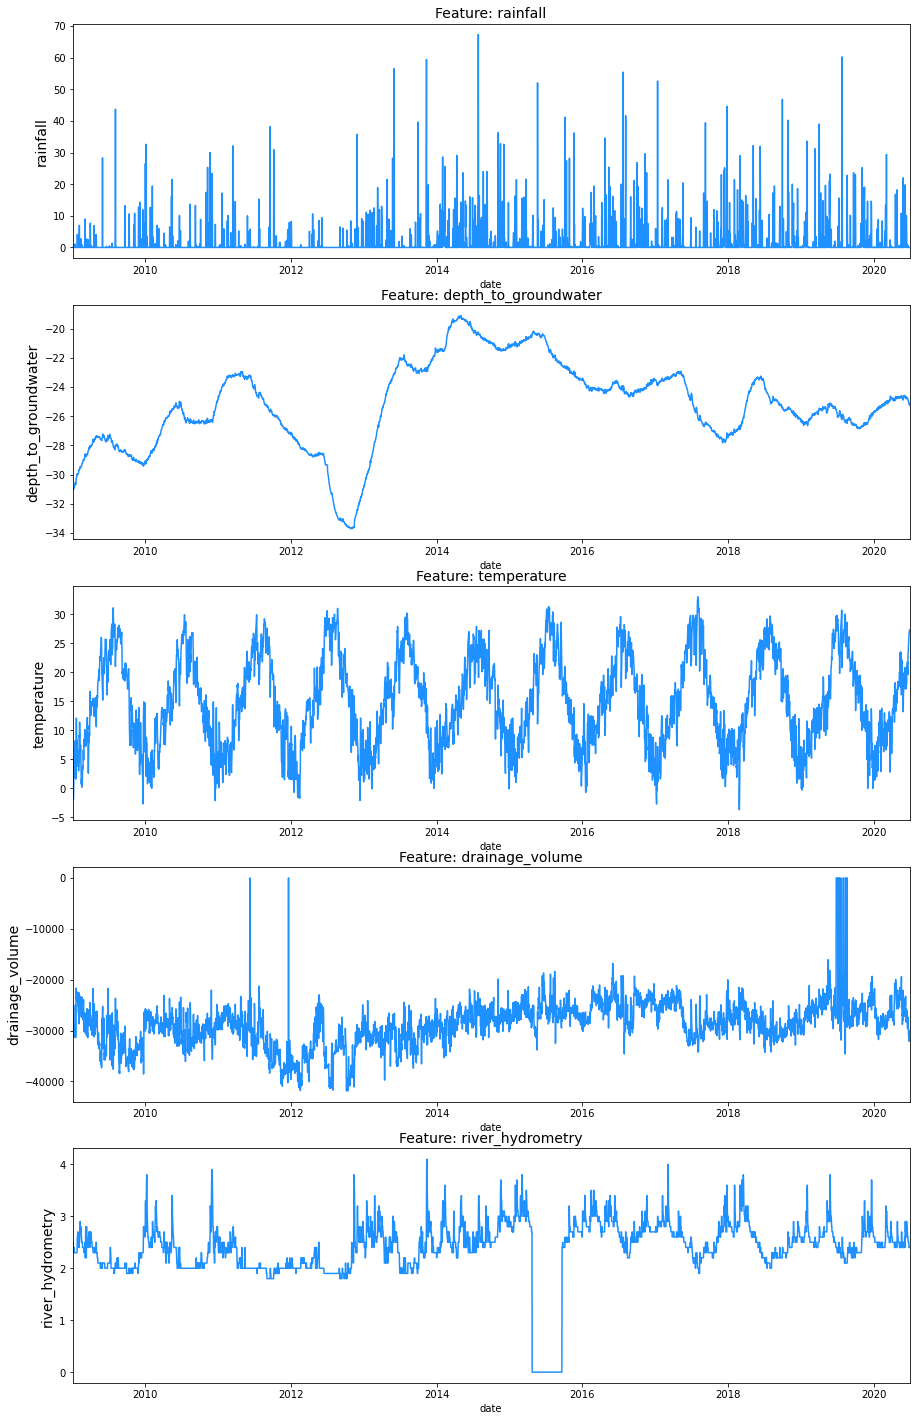

In [12]:
# To compelte the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

## Data Preprocessing

### Chronological Order and Equidistant Timestamps

- The chronological order dapat dilakukan dengan sorting dataframe based on timestamps
- Equidisant timestamps mengindikasikan interval waktu yang konstan (untuk cek dapat dilihat dengan melakukan selisih antar timestamp(date))

In [13]:
df = df.sort_values(by='date')
# Check time intervals
df['delta'] = df['date'] - df['date'].shift(1)

df[['date', 'delta']].head()

,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [14]:
df.describe()

,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry,delta
count,4199.000000,4172.000000,4199.000000,4198.000000,4199.000000,4198
mean,1.556633,-25.182534,15.030293,-28669.156619,2.372517,1 days 00:00:00
std,5.217923,2.945074,7.794871,4570.686434,0.589088,0 days 00:00:00
min,0.000000,-33.710000,-3.700000,-41890.176000,0.000000,1 days 00:00:00
25%,0.000000,-26.860000,8.800000,-31082.832000,2.100000,1 days 00:00:00
50%,0.000000,-25.170000,14.700000,-28389.744000,2.400000,1 days 00:00:00
75%,0.100000,-23.270000,21.400000,-26042.904000,2.700000,1 days 00:00:00
max,67.300000,-19.100000,33.000000,0.000000,4.100000,1 days 00:00:00


## Handling Missing Value

In [15]:
df.drop(['delta'], axis=1, inplace=True)
df.isnull().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

solusi untuk missing value:
- fill NaN with 0
- fill with mean
- FFill (isi dengan nilai setelah NaN tsb)
- fill with interpolate

In [16]:
## replace zeros value as anomaly into null value and then will be filling null value
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)
df.isnull().sum()

date                      0
rainfall                  0
depth_to_groundwater     27
temperature               0
drainage_volume          26
river_hydrometry        150
dtype: int64

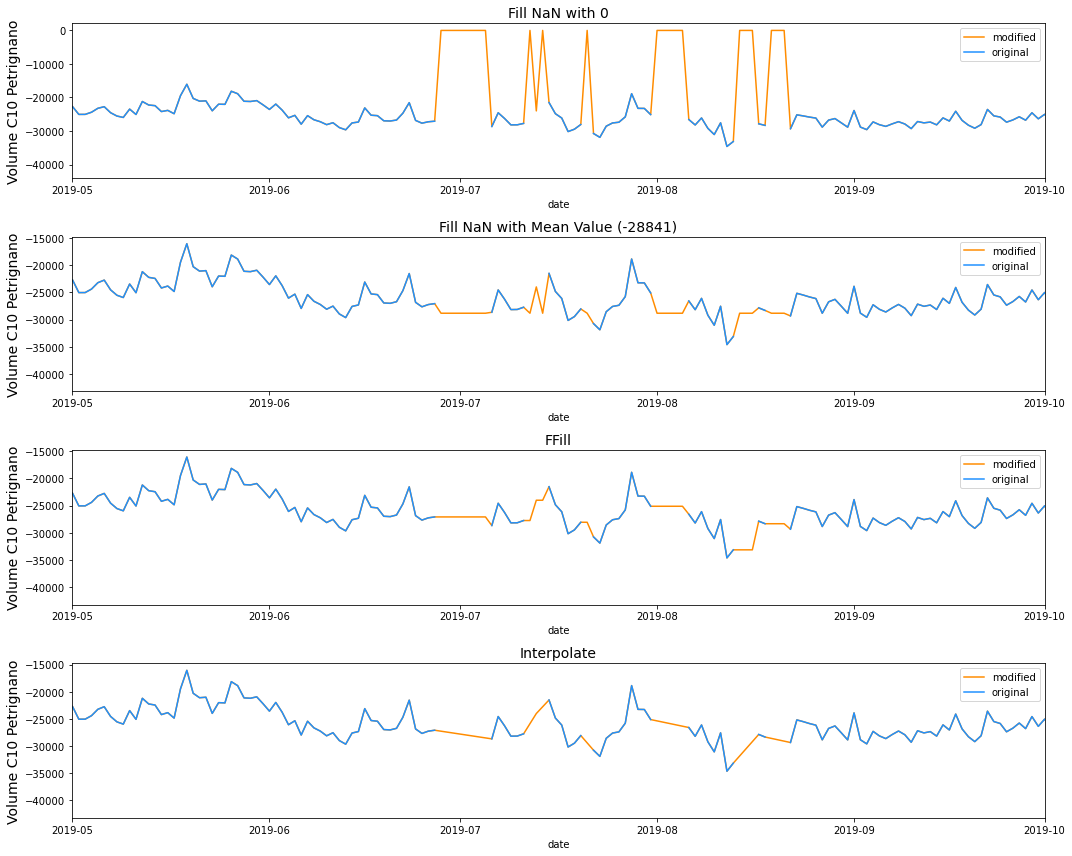

In [17]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

best option yaitu menggunakan interpolasi

In [18]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()

## Resampling (Downsampling)

In [19]:
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


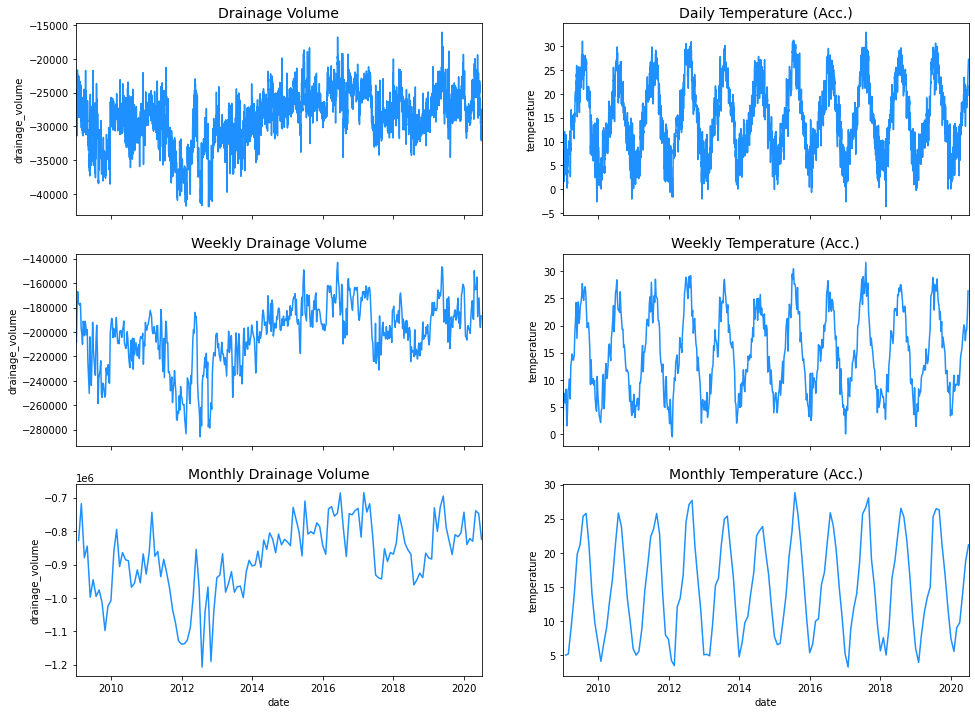

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(df['date'], df['drainage_volume'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

resampled_df = df[['date','drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['drainage_volume'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(df['date'], df['temperature'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['date','temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['temperature'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

In [21]:
## Downsampling (menguragi frekuensi data) dari Days menjadi weekly terlihat lebih smooth
downsample = df.resample('7D', on='date').mean().reset_index()
df = downsample.copy()
print(df.shape)
df.head()

(600, 6)


,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01,0.000000,-31.048571,1.657143,-28164.918857,2.371429
1,2009-01-08,0.285714,-30.784286,4.571429,-29755.789714,2.314286
2,2009-01-15,0.028571,-30.420000,7.528571,-25463.190857,2.300000
3,2009-01-22,0.585714,-30.018571,6.214286,-23854.422857,2.500000
4,2009-01-29,1.414286,-29.790000,5.771429,-25210.532571,2.500000


# Stationary

Stationary means:
- Constant mean and mean is not time-independent
- Constant variance and variance isn't time-independent
- Constant Covariance and covariance isn't time-independet


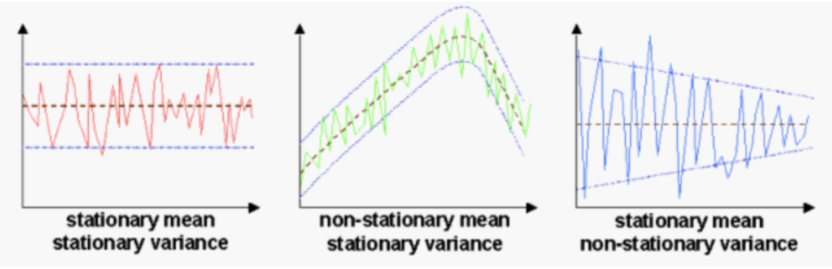

In [22]:
from IPython.display import Image
Image(filename='C:\\Users\\eka.yulianto\\Pictures\\TS\\Stationary.png',width=800, height=400)

Untuk cek Stationary dapat dilakukan dengan visual secara langsung atau apabila ingin lebih jelas menggunakan ADFuler Testing

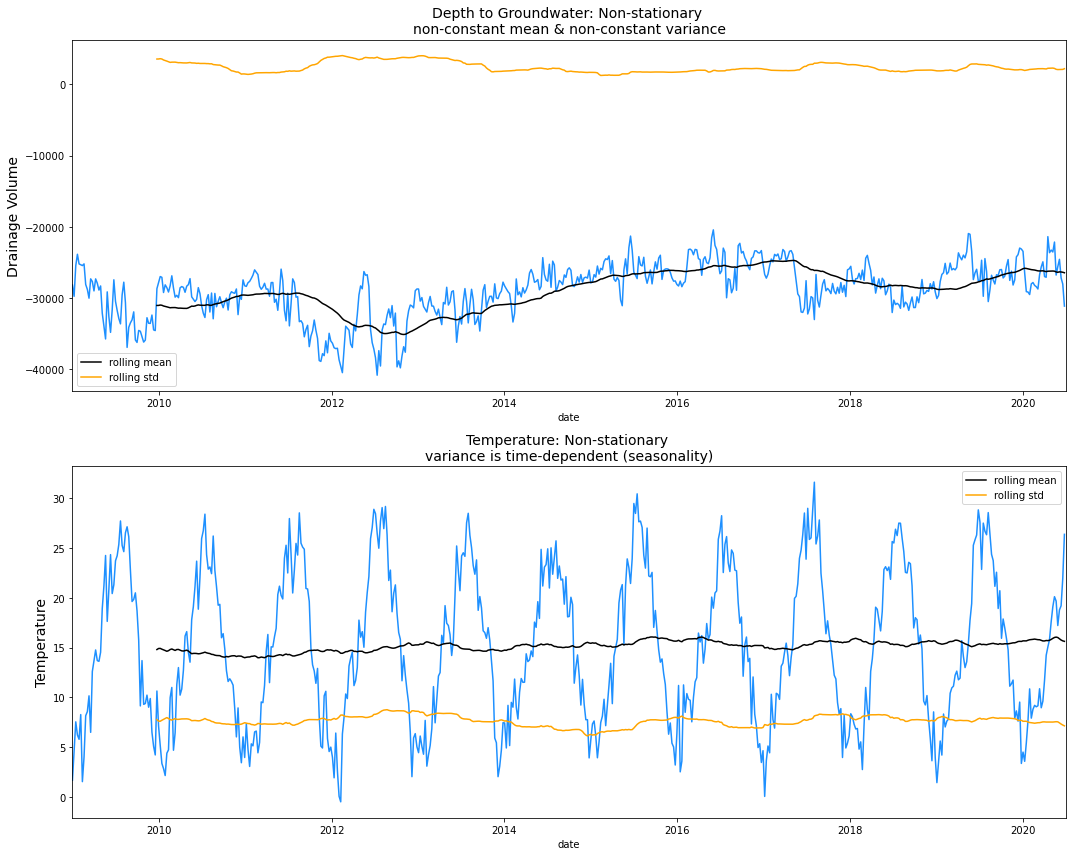

In [23]:
## menggunakan rolling window 1 tahun atau 52 minggu
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

dari dua sample diatas terlihat secara gamblang bahwa  pada data Non-Stationary

In [24]:
## ADFULLER TEST
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['depth_to_groundwater'].values)
result

(-2.880201649316664,
 0.047699190920208426,
 7,
 592,
 {'1%': -3.441444394224128,
  '5%': -2.8664345376276454,
  '10%': -2.569376663737217},
 -734.3154255877625)

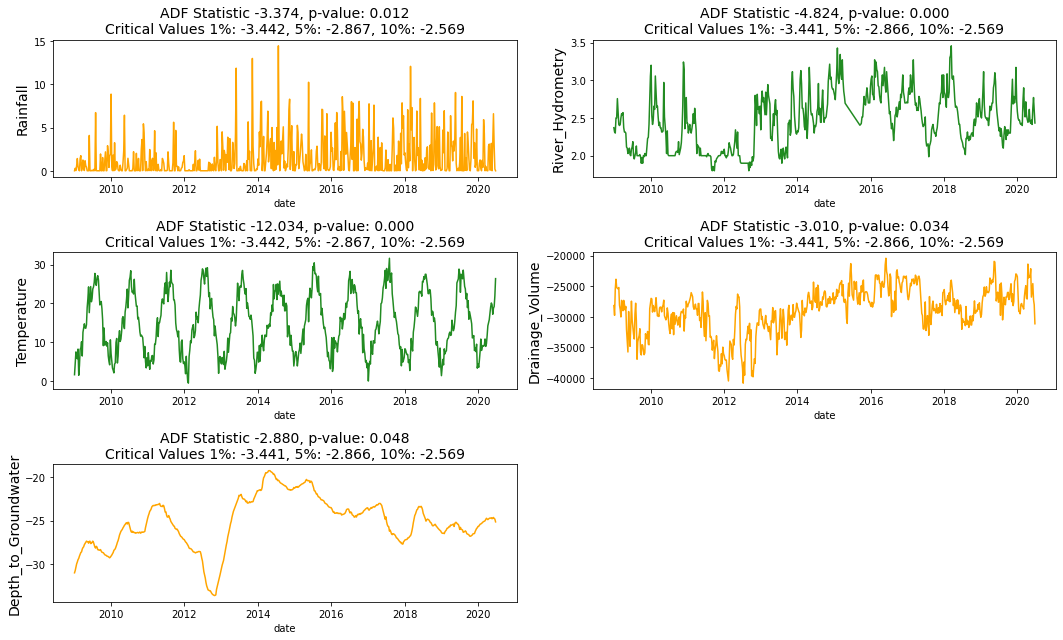

In [25]:
## Cek setiap variablenya
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

Berdasarkan hasil ADFuller Test data tersebut bersifat Stationary. 
Apabila terdapat data yang Non-Stationary dapat menggunakan tehnik Transforming (Log) dan Differencing

### Transforming

<AxesSubplot:xlabel='depth_to_groundwater_log', ylabel='Density'>

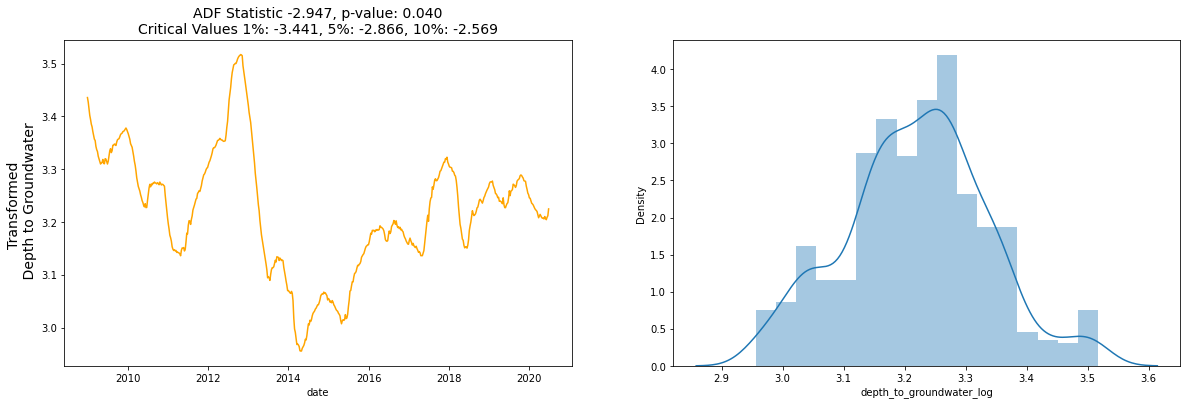

In [26]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])

sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

### Differencing

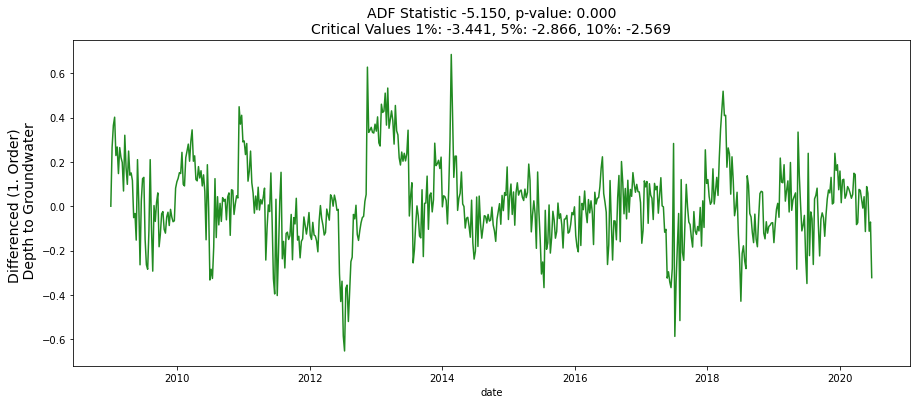

In [27]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

# Feature Engineering

In [28]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head(20)

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1
5,2009-02-05,2009,2,5,36,6,1,1
6,2009-02-12,2009,2,12,43,7,1,1
7,2009-02-19,2009,2,19,50,8,1,1
8,2009-02-26,2009,2,26,57,9,1,1
9,2009-03-05,2009,3,5,64,10,1,2


## Time Series Decomposition

- Level
- Trend
- Seasonality
- Noise

All series have a level and noise. The trend and seasonality components are optional.


Combininng Decomposition

- Additive: y(t) = Level + Trend + Seasonality + Noise
- Multiplicative: y(t) = Level * Trend * Seasonality * Noise

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

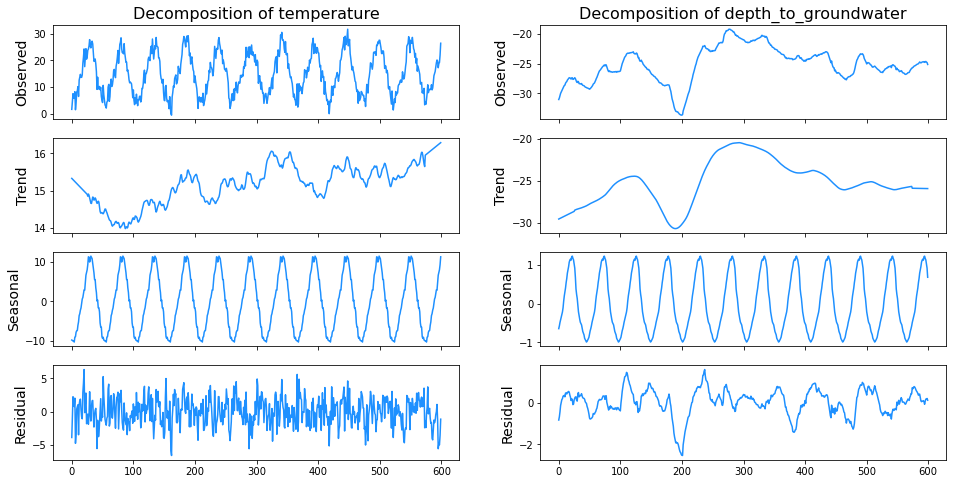

In [30]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    
    res = seasonal_decompose(df[column], freq=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

## Lag (shift)

In [31]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

In [32]:
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry,depth_to_groundwater_log,depth_to_groundwater_diff_1,year,month,...,river_hydrometry_seasonal_shift_b_2m,river_hydrometry_seasonal_shift_b_1m,river_hydrometry_seasonal_shift_1m,river_hydrometry_seasonal_shift_2m,river_hydrometry_seasonal_shift_3m,depth_to_groundwater_seasonal_shift_b_2m,depth_to_groundwater_seasonal_shift_b_1m,depth_to_groundwater_seasonal_shift_1m,depth_to_groundwater_seasonal_shift_2m,depth_to_groundwater_seasonal_shift_3m
0,2009-01-01,0.000000,-31.048571,1.657143,-28164.918857,2.371429,3.435553,0.000000,2009,1,...,0.206555,0.152668,NaN,NaN,NaN,0.066340,-0.362900,NaN,NaN,NaN
1,2009-01-08,0.285714,-30.784286,4.571429,-29755.789714,2.314286,3.427004,0.264286,2009,1,...,0.210803,0.235327,NaN,NaN,NaN,0.203030,-0.275904,NaN,NaN,NaN
2,2009-01-15,0.028571,-30.420000,7.528571,-25463.190857,2.300000,3.415100,0.364286,2009,1,...,0.318394,0.312137,NaN,NaN,NaN,0.304813,-0.212800,NaN,NaN,NaN
3,2009-01-22,0.585714,-30.018571,6.214286,-23854.422857,2.500000,3.401816,0.401429,2009,1,...,0.292617,0.260525,NaN,NaN,NaN,0.407139,-0.103563,NaN,NaN,NaN
4,2009-01-29,1.414286,-29.790000,5.771429,-25210.532571,2.500000,3.394173,0.228571,2009,1,...,0.200299,0.206555,0.207547,NaN,NaN,0.545598,0.066340,-0.643767,NaN,NaN


# EDA

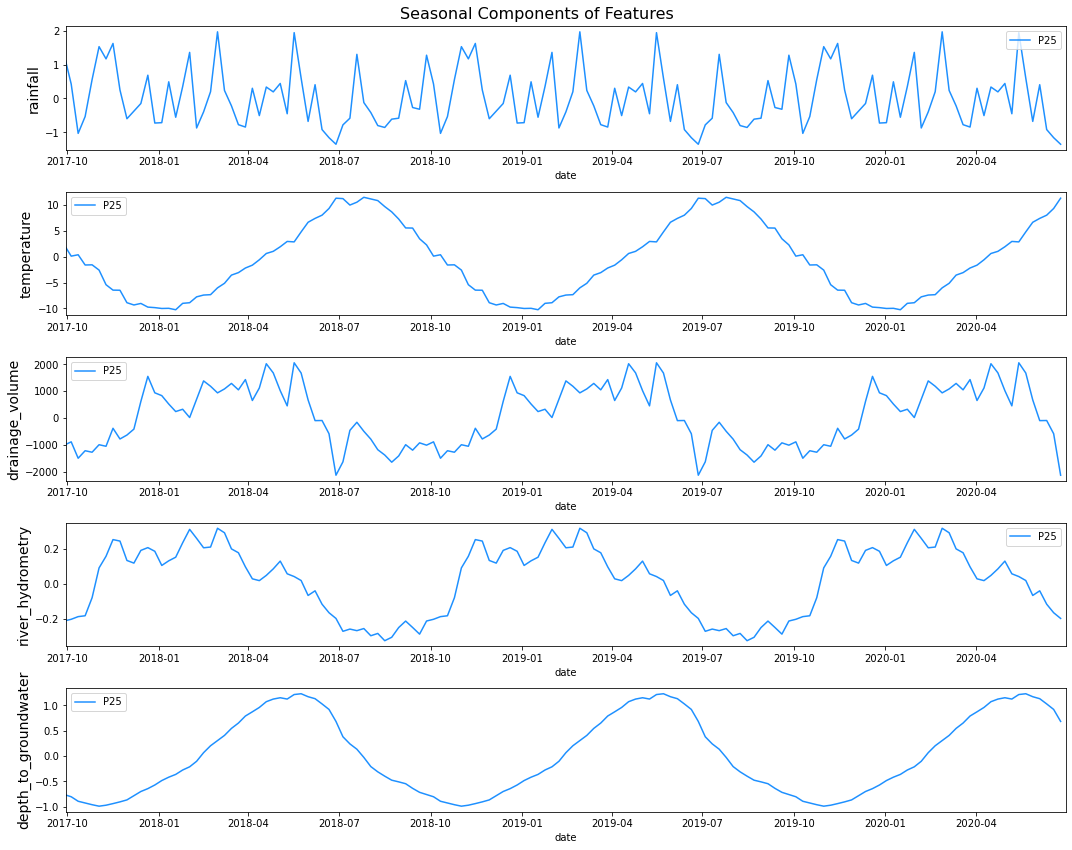

In [33]:
## Seasonality
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

dari gambar diatas terlihat jelas letak peak and trough

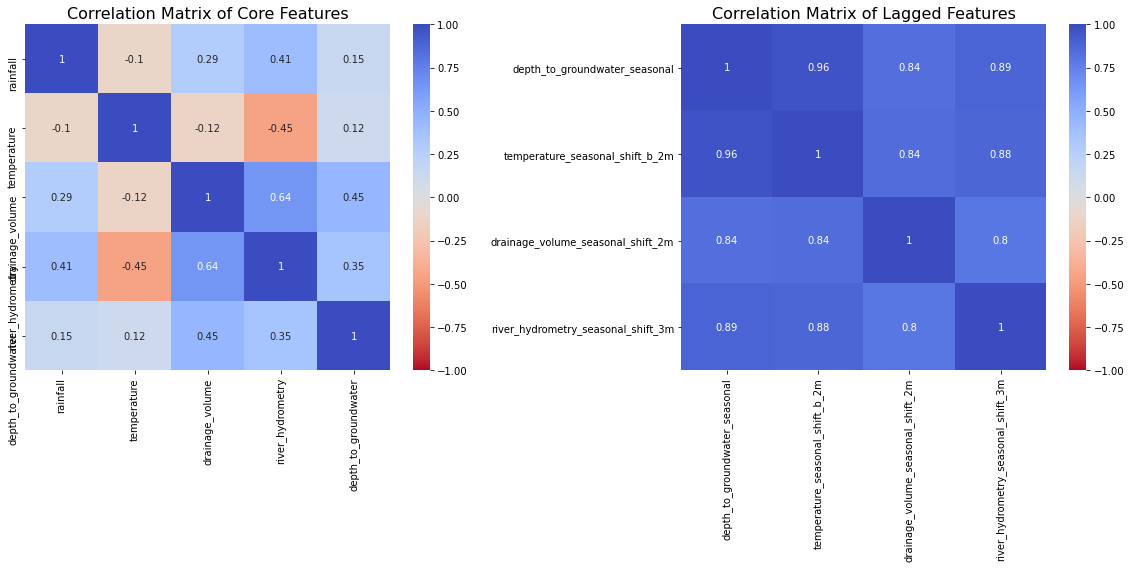

In [34]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'depth_to_groundwater_seasonal',         
    'temperature_seasonal_shift_b_2m',
    'drainage_volume_seasonal_shift_2m', 
    'river_hydrometry_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

dari hasil correlation matrix terlihat bahwa setelah dilakukan shiffting mengalami peningkatan nilai korelasi

## Autocorrelation Analysis

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 50 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   date                                      600 non-null    datetime64[ns]
 1   rainfall                                  600 non-null    float64       
 2   depth_to_groundwater                      600 non-null    float64       
 3   temperature                               600 non-null    float64       
 4   drainage_volume                           600 non-null    float64       
 5   river_hydrometry                          600 non-null    float64       
 6   depth_to_groundwater_log                  600 non-null    float64       
 7   depth_to_groundwater_diff_1               600 non-null    float64       
 8   year                                      600 non-null    int64         
 9   month                           

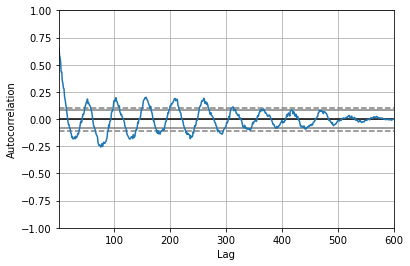

In [36]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

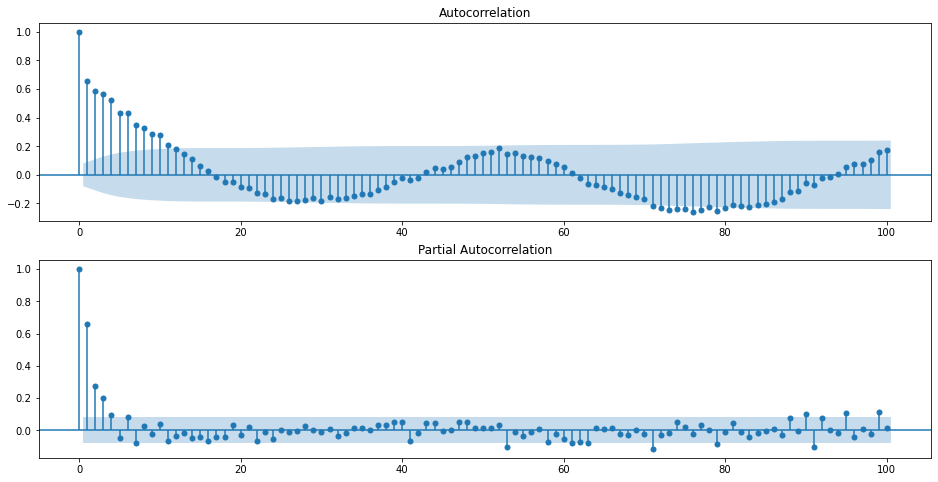

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

# Model

TS dapat berupa:
    
    - Univariate: TS yang memiliki single variable terhadap waktu
    - Multivariate: TS yang memiliki Multiple variable terhadap waktu

#### Model untuk Univariate (depth_to_groundwater)

In [38]:
## train data (85%) dan test data (15%)
train_size = int(0.85 * len(df))                       
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


###### 1. ARIMA Model

In [39]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(2,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(90)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 0.8991441147535978


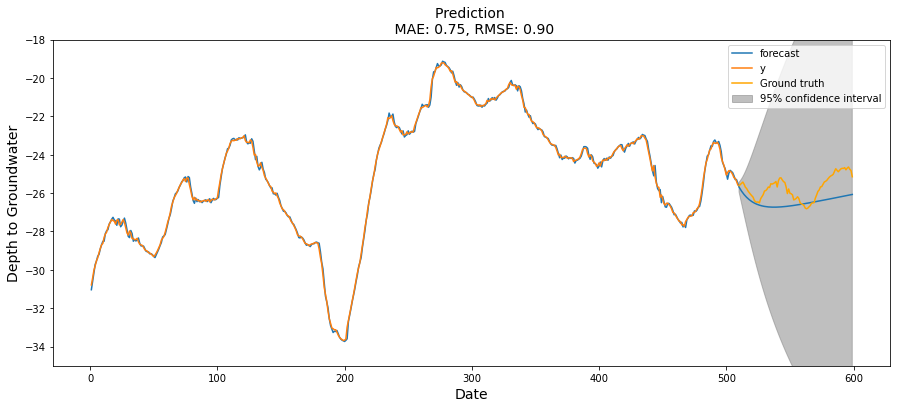

In [40]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model_fit.plot_predict(1, 599, ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

ax.set_ylim(-35, -18)
plt.show()

Zoom Version

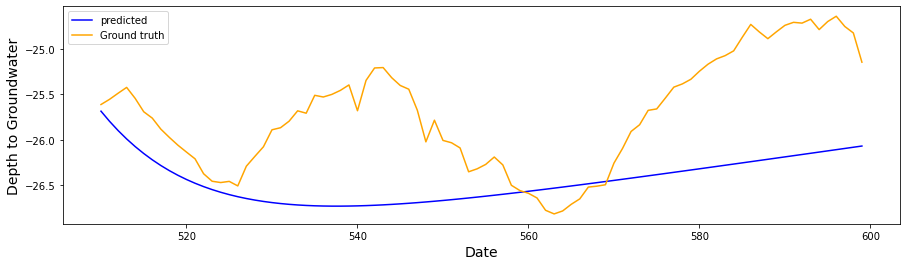

In [41]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()